In [ ]:
# https://github.com/pmarcelino/blog/blob/master/dogs_cats/dogs_cats.ipynb

In [ ]:
%cd /content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data

In [ ]:
img_width, img_height = 224, 224  # Default input size for VGG16

In [ ]:
train_size, validation_size, test_size = 3000, 1000, 1000

base_dir = '/content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data'
train_dir = '/content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data/train'
validation_dir = '/content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data/validation'
test_dir = '/content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data/test'
train_cats_dir = '/content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data/train/cats'
train_dogs_dir = '/content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data/train/dogs'

In [ ]:
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_cats_dir)
    show_pictures(train_dogs_dir)

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

In [ ]:
# conv_base.summary()

In [ ]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)


In [ ]:
print(train_features)
print(train_labels)

In [ ]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
model = keras.models.load_model('/content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data/dogs_cat_fcl.h5')

In [ ]:
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

In [ ]:
model.save('dogs_cat_fcl.h5')

In [ ]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
model = keras.models.load_model('/content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data/dogs_cat_fcl.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
model = keras.models.load_model('/content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data/dogs_cat_fcl.h5')

In [ ]:
test_cats_dir = '/content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data/test/cats'
test_dogs_dir = '/content/drive/MyDrive/Thesis/AdversarialExamples-CatsDogs/data/test/dogs'

In [ ]:
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_cats_dir, test_dogs_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Cat')
        else:
            print('Dog')

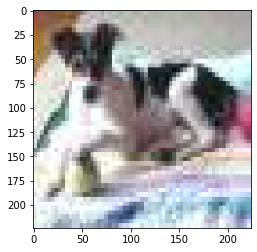

Dog


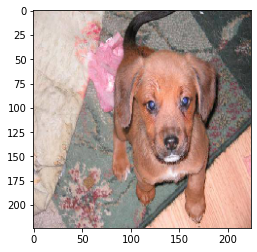

Dog


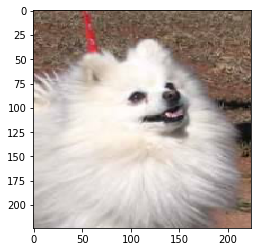

Dog


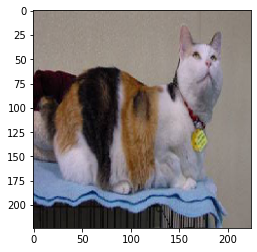

Cat


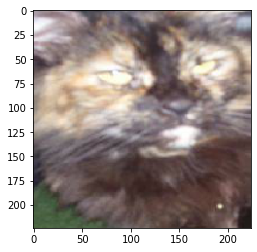

Dog


In [ ]:
# Visualize predictions
visualize_predictions(model, 5)